In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Linear regression

See [The wikipedia page](https://en.wikipedia.org/wiki/Ridge_regression) on how to handle sparse X. This is why we regularize.

In [4]:
import numpy as np
import pandas as pd

class Linear_regression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self._beta = None

    def fit(self, X, y, alpha=1.0):
        # Add a column of ones to the feature matrix to represent the intercept term
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))

        # Calculate beta using the Ridge regression formula
        # This prevents issues with invertability when the X matrix is sparse, which often occurs after dummy 
        # encoding.
        
        identity = alpha * np.eye(X.shape[1])
        self._beta = np.linalg.inv(X.T @ X + identity) @ X.T @ y

        # Extract the intercept and coefficient terms from beta
        self.intercept_ = self._beta[0]
        self.coef_ = self._beta[1:]

    def predict(self, X):
        # Add a column of ones to the feature matrix to represent the intercept term
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))
        
        return X @ self._beta


In [5]:
df = pd.read_csv("data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], dtype = int, drop_first = True) 
X = df.drop("charges", axis=1)
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123) 

In [7]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [8]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
300,36,27.55,3,1,0,0,0,0
904,60,35.10,0,0,0,0,0,1
670,30,31.57,3,1,0,0,1,0
617,49,25.60,2,1,1,0,0,1
373,26,32.90,2,1,1,0,0,1


In [9]:
lm = Linear_regression()
lm.fit(X,y)

In [10]:
lm.coef_

array([  255.40603775,   331.97620253,   470.7497847 ,  -137.9745946 ,
       23726.00962355,  -383.20301721, -1025.54237336,  -977.99210922])

In [11]:
lm.predict(X.loc[:2])

array([25253.95573882,  3506.46531235,  6746.40358336])

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

In [14]:
lm.coef_

array([  256.85635254,   339.19345361,   475.50054515,  -131.3143594 ,
       23848.53454191,  -352.96389942, -1035.02204939,  -960.0509913 ])

In [15]:
lm.predict(X.loc[:2])

array([25293.7130284 ,  3448.60283431,  6706.9884907 ])

Returns pretty similar results compared to sklearn.

# Logistic regression
- Mini batch gradient descent

See [this](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc) for derivation of formulas.

Short explanation:
- Cost function $L(\hat y, y)=-ylog(\hat y)-(1-y)log(1-\hat y)$
- Prediction $\hat y=\sigma(z)$ where $\sigma = \frac{1}{1+e^{-z}}$
- $z=\beta_0x_0+..\beta_m x_m=\mathbf{X} \mathbf \beta$; $\mathbf X \in \mathbb R^{n \times (m+1)}, \mathbf \beta \in \mathbb R^n$

Note that $L(\hat y, y)=L(\sigma(z), y)=L(\sigma(\beta_0x_0+..\beta_m x_m))$

Hence, $\frac{\partial L}{\partial \beta_j}=\frac{\partial L}{\partial \hat y}\cdot \frac{\partial \hat y}{\partial z}\cdot \frac{\partial z}{\partial \beta_j}$

- $\frac{\partial L}{\partial \hat y}=(\frac{-y}{\hat y})+(\frac{1-y}{1-\hat y})$
- $\frac{\partial \hat y}{\partial z}= \hat y(1-\hat y)$
- $\frac{\partial z}{\partial \beta_j}=x_j$

Note $x_0=1$ (intercept).

Which then implies, 

$\frac{\partial L}{\partial \beta_j}=(\hat y - y)x_j$

In [16]:
import numpy as np

class LogisticClassifier:
    def __init__(self, eta=0.001, max_iter=1000, batch_size=64):
        self.eta = eta
        self.max_iter = max_iter
        self.batch_size = batch_size
        self._beta = None
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Add a column of ones to X
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))
        
        # Initialize Beta to small random numbers (bias to 0)
        self._beta = np.zeros(n_features + 1)
        self._beta[1:] = 0.01 * np.random.rand(n_features)
        
        for _ in range(self.max_iter):
            
            # Shuffle the samples
            shuffle_index = np.random.permutation(n_samples)
            X = X[shuffle_index]
            y = y[shuffle_index]

            # Divide the samples into batches (exclude last batch in range so that it always is 64 (or specified), never less)
            for i in range(0, n_samples-self.batch_size, self.batch_size):
                X_batch = X[i:i + self.batch_size] #(64, features+1 bias)
                y_batch = y[i:i + self.batch_size] #(64,)

                # Compute the predicted probabilities
                y_pred = self.sigmoid(X_batch @ self._beta)
                
                # Compute the gradient
                gradient = (1 / self.batch_size) * (y_pred - y_batch) @ X_batch
                                
                # Update Beta
                self._beta -= self.eta * gradient
            
    def predict(self, X):
        # Add a column of ones to X
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))
        
        # Compute the predicted probabilities
        y_pred = self.sigmoid(X @ self._beta)
        
        # Return the predicted class labels
        return (y_pred > 0.5).astype(int)


In [17]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [19]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123) 

In [20]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [21]:
lm = LogisticClassifier()
lm.fit(X_train_sc,y_train)

In [212]:
pred = lm.predict(X_test_sc)

In [213]:
accuracy_score(y_test, pred)

0.8008658008658008

In [214]:
lm._beta

array([-0.63248168,  0.25331117,  0.66245727, -0.05999426,  0.02475512,
        0.02293915,  0.43070819,  0.2123497 ,  0.19620902])

In [215]:
from sklearn.linear_model import LogisticRegression

In [216]:
lm = LogisticRegression()
lm.fit(X_train_sc,y_train)

LogisticRegression()

In [218]:
pred = lm.predict(X_test_sc)

In [219]:
accuracy_score(y_test, pred)

0.7965367965367965

In [220]:
lm.coef_

array([[ 0.38302541,  1.05971527, -0.20032383,  0.03797612, -0.19125075,
         0.70206942,  0.28862765,  0.12327709]])

Roughly same results, actually better but most likely due to small randomness

# Decision trees

Works by splitting features at certain values that provide the most "pure" nodes.

Entropy: $$E = -\sum_{i=1}^{n}p_i \log_2 p_i$$
- where E is the entropy, n is the number of classes, and p is the probability of a data point belonging to a particular class.

Gain (IG) $$IG = E_{parent} - \sum_{i=1}^{m}\frac{N_i}{N}E_i$$
- where IG is the information gain, E is the entropy, N is the total number of data points, and m is the number of subgroups resulting from the split.



In [181]:
import numpy as np

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        """
        Initialize the decision tree classifier with optional maximum depth parameter.

        Parameters:
        max_depth (int): The maximum depth of the decision tree. If not provided, the tree can grow without any limit.

        Returns:
        None
        """
        
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        """
        Build the decision tree based on the input data and labels.

        Parameters:
        X (np.array or pd.DataFrame): The input data.
        y (np.array): The labels for the input data.

        Returns:
        None
        """
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.

        Parameters:
        X (np.array): The input data.
        y (np.array): The labels for the input data.
        depth (int): The current depth of the tree.

        Returns:
        DecisionNode or LeafNode: The root node of the subtree.
        """
        
        n_samples, n_features = X.shape
        n_classes = np.unique(y).size

        # If the maximum depth is reached or there is only one class, return a leaf node
        if self.max_depth and depth >= self.max_depth or n_classes == 1:
            leaf = LeafNode()
            leaf.set_label(self._majority_class(y))
            return leaf

        # Find the best split point
        best_split_point, best_gain = self._find_best_split_point(X, y) #(feature index, value), # Information Gain

        # If no gain was made, return a leaf node
        if best_gain == 0:
            leaf = LeafNode()
            leaf.set_label(self._majority_class(y))
            return leaf

        # Create a new decision node and split the data
        decision = DecisionNode()
        decision.set_split_point(best_split_point)
        left_indexes, right_indexes = self._split_data(X, best_split_point)
        decision.set_left_child(self._build_tree(X[left_indexes], y[left_indexes], depth + 1))
        decision.set_right_child(self._build_tree(X[right_indexes], y[right_indexes], depth + 1))
        
        return decision #returns the DecisionNode object stored in the decision variable to the parent node.

    def _find_best_split_point(self, X, y):
        """
        Find the best split point in the data based on information gain.

        Parameters:
        X (np.array): The input data.
        y (np.array): The labels for the input data.

        Returns:
        tuple: A tuple containing the best split point (feature index and value) and the corresponding information gain.
        """
        
        # Calculate the initial entropy
        initial_entropy = self._entropy(y)

        best_gain = 0
        best_split_point = None

        # Iterate over all features and find the best split point
        for feature_index in range(X.shape[1]):
            values = X[:, feature_index]
            unique_values = np.unique(values)

            for value in unique_values: # probably not very efficient
                split_point = (feature_index, value)
                left_indexes, right_indexes = self._split_data(X, split_point)
                if len(left_indexes) == 0 or len(right_indexes) == 0:
                    continue

                # Calculate the entropy gain
                left_entropy = self._entropy(y[left_indexes])
                right_entropy = self._entropy(y[right_indexes])
                gain = initial_entropy - (left_entropy * len(left_indexes) + right_entropy * len(right_indexes)) / len(y)

                # Update the best gain and split point if necessary
                if gain > best_gain:
                    best_gain = gain
                    best_split_point = split_point

        return best_split_point, best_gain

    def _split_data(self, X, split_point):
        """
        Split the input data into two subsets based on a given split point.

        Parameters:
        X (np.array): The input data.
        split_point (tuple): A tuple containing the feature index and value to use for the split.

        Returns:
        tuple: A tuple containing the left and right indexes of the split data.
        """
        
        feature_index, value = split_point
        left_indexes = np.where(X[:, feature_index] <= value)[0]
        right_indexes = np.where(X[:, feature_index] > value)[0]
        return left_indexes, right_indexes

    def _majority_class(self, y):
        """
        Find the majority class label in the input data.

        Parameters:
        y (np.array): The labels for the input data.

        Returns:
        int or str: The majority class label.
        """
        
        unique, counts = np.unique(y, return_counts=True)
        return unique[counts.argmax()]
    
    def _entropy(self, y):
        """
        Calculate the entropy of the input data.

        Parameters:
        y (np.array): The labels for the input data.

        Returns:
        float: The entropy of the input data.
        """
        
        # Calculate the probabilities of each class
        unique, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)

        # Calculate the entropy
        entropy = -np.sum(probs * np.log(probs))

        return entropy

    def predict(self, X):
        """
        Predict the labels for the input data.

        Parameters:
        X (np.array or pd.DataFrame): The input data.

        Returns:
        np.array: The predicted labels for the input data.
        """
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        # Initialize an array to store the predictions
        y_pred = np.empty(X.shape[0])

        # Iterate over the rows of the input data and make predictions
        for i, x in enumerate(X):
            y_pred[i] = self._predict_sample(self.root, x)

        return y_pred

    def _predict_sample(self, node, x):
        """
        Recursively traverse the tree to make a prediction for a single sample.

        Parameters:
        node (DecisionNode or LeafNode): The current node in the tree.
        x (np.array): The input sample.

        Returns:
        int or str: The predicted label for the input sample.
        """
        
        if isinstance(node, LeafNode):
            return node.label

        # Follow the left or right branch based on the split point
        feature_index, value = node.split_point
        if x[feature_index] <= value:
            return self._predict_sample(node.left_child, x)
        else:
            return self._predict_sample(node.right_child, x)

class DecisionNode:
    def __init__(self):
        self.split_point = None
        self.left_child = None
        self.right_child = None

    def set_split_point(self, split_point):
        """
        Set the split point for the decision node.

        Parameters:
        split_point (tuple): A tuple containing the feature index and value to use for the split.

        Returns:
        None
        """
        
        self.split_point = split_point

    def set_left_child(self, child):
        """
        Set the left child of the decision node.

        Parameters:
        child (DecisionNode or LeafNode): The left child of the decision node.

        Returns:
        None
        """
        
        self.left_child = child

    def set_right_child(self, child):
        """
        Set the right child of the decision node.

        Parameters:
        child (DecisionNode or LeafNode): The right child of the decision node.

        Returns:
        None
        """
        
        self.right_child = child

class LeafNode:
    def __init__(self):
        self.label = None

    def set_label(self, label):
        """
        Set the label for the leaf node.

        Parameters:
        label (int or str): The label for the leaf node.

        Returns:
        None
        """
        
        self.label = label

    def predict(self, x):
        """
        Predict the labels for the input data.

        Parameters:
        X (np.array or pd.DataFrame): The input data.

        Returns:
        np.array: The predicted labels for the input data.
        """
        return self.label


In [182]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

In [183]:
pred = tree.predict(X_test)
accuracy_score(y_test, pred)

0.7792207792207793

In [184]:
from sklearn.tree import DecisionTreeClassifier

In [185]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [186]:
pred = tree.predict(X_test)
accuracy_score(y_test, pred)

0.7142857142857143

# Random forest

In [187]:
import numpy as np

class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, max_features=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.estimators = []
        self.n_classes = None

    def fit(self, X, y):
        # Build the specified number of decision trees
        self.n_classes = np.unique(y).size
        
        for i in range(self.n_estimators):
            # Build a decision tree
            clf = DecisionTreeClassifier(max_depth=self.max_depth)

            # Bootstrap the data if desired
            if self.bootstrap:
                X_bootstrapped, y_bootstrapped = self._bootstrap(X, y)
            else:
                X_bootstrapped, y_bootstrapped = X, y

            # Subsample the features if desired
            if self.max_features:
                X_bootstrapped = self._subsample_features(X_bootstrapped)

            # Fit the decision tree to the bootstrapped data
            clf.fit(X_bootstrapped, y_bootstrapped)

            # Save the decision tree
            self.estimators.append(clf)

    def _bootstrap(self, X, y):
        # Create a random sample of the indexes with replacement
        indexes = np.random.randint(0, len(X), len(X))

        # Select the bootstrapped samples and labels
        X_bootstrapped = X.to_numpy()[indexes]
        y_bootstrapped = y[indexes]

        return X_bootstrapped, y_bootstrapped

    def _subsample_features(self, X):
        # Create a random sample of the feature indexes with replacement
        feature_indexes = np.random.randint(0, X.shape[1], self.max_features)

        # Select the subsampled features
        X_subsampled = X[:, feature_indexes]

        return X_subsampled

    def predict(self, X):
        # Create an empty array to store the votes for each class
        votes = np.zeros((X.shape[0], self.n_classes))

        # Make predictions with each decision tree
        for clf in self.estimators:
            y_pred = clf.predict(X)
            for i, c in enumerate(y_pred):
                votes[i, int(c)] += 1

        # Return the class with the most votes
        return np.argmax(votes, axis=1)



In [188]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)

In [189]:
pred = forest.predict(X_test)
accuracy_score(y_test, pred)

C:\Users\erlen\.conda\envs\IND320\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\erlen\.conda\envs\IND320\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\erlen\.conda\envs\IND320\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\erlen\.conda\envs\IND320\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\erlen\.conda\envs\IND320\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\erlen\.conda\envs\IND320\lib\site-packages\sklearn\base.py:457: UserWar

0.7619047619047619

In [190]:
from sklearn.ensemble import RandomForestClassifier

In [191]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [192]:
pred = forest.predict(X_test)
accuracy_score(y_test, pred)

0.7878787878787878

# Visualize decision tree

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=4)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

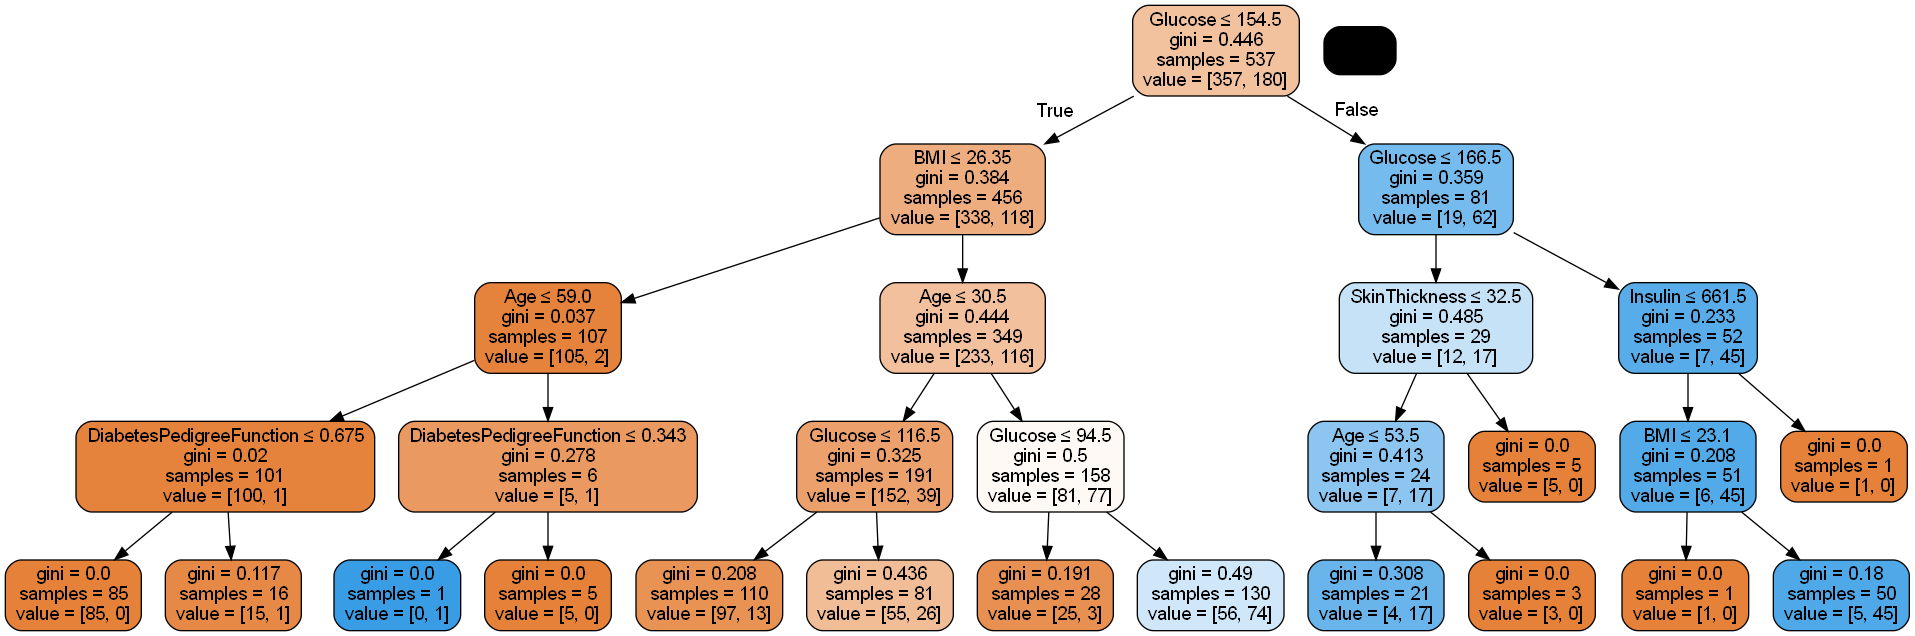

In [5]:
dot_data = StringIO()
g = export_graphviz(decision_tree, filled=True, rounded=True,special_characters=True, feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(g)  

Image(graph.create_png())